<a href="https://colab.research.google.com/github/NahianAlindo/Artificial_Intelligence/blob/master/Model_with_blocks_Bi_LSTM_pre_identity_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive and Accelerator status

In [1]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import os
try:
    tpu = False     
    assert torch.cuda.is_available()
    gpu = True
    ! nvidia-smi
except:
    try:
        tpu = True
        gpu = False
        if 'COLAB_TPU_ADDR' not in os.environ:
            print('ERROR: Not connected to a TPU runtime')
        else:
            tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
            print ('TPU address is', tpu_address)
        import tensorflow as tf
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_address)
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print('==========MEM=============')
        ! cat /proc/meminfo
        print("============CPU============")
        ! cat /proc/cpuinfo
        from psutil import *
        cpu_count()
        cpu_stats()
        
print("============STORAGE============")
! df -h

Tue Feb 15 11:44:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    29W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import *
virtual_memory()

svmem(total=13622190080, available=11652698112, percent=14.5, used=1759145984, free=7376404480, active=2092605440, inactive=3831431168, buffers=137637888, cached=4349001728, shared=1220608, slab=180477952)

In [5]:
! pip install keras_tuner
! pip install tensorflow-addons

     |████████████████████████████████| 98 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


# Import Libraries

In [6]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow_addons.optimizers import CyclicalLearningRate
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.constraints import max_norm as maxnorm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import *
import seaborn as sns
import tensorflow.keras.metrics as metrics
import tensorflow.keras as keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions for loading dataset, plots and performance

In [7]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [8]:
def get_test_performance(model, X_test, test_label):
    score=model.evaluate(X_test,test_label,verbose=1)
    print(f'Test loss:{score[0]}')
    print(f'Test accuracy:{score[1]}')
    print(f'Test Recall: {score[3]}')
    print(f'Test AUC: {score[2]}')

In [9]:
def plot_performance(X_train, train_label, history):
    plt.plot(history.history['accuracy'])
    try:
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
    except:
        pass
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

    plt.plot(history.history['loss'])
    try:
        plt.plot(history.history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    try:
        plt.legend(['val'], loc='upper left')
    except:
        pass
    plt.show()

In [10]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

In [11]:
activation = ['tanh','relu','sigmoid','softplus','softsign','selu','elu','exponential','softmax'] # None
activs = ['tanh','relu','sigmoid','softplus','softsign','selu','elu','exponential','softmax']
bool_ = [True,False]
n_filters = [32,64,128,256,512]
inits = ['glorot_uniform','random_normal','random_uniform','truncated_normal','zeros','ones','glorot_normal','he_normal','he_uniform','orthogonal','constant','variance_scaling']
regularizers = ['l1','l2','l1_l2'] # None
dropouts = [0.0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
k_size = [3,5,7,8,9]
strides = [1,2,5]
pad = ['same','valid']
seed = 42

# Tuner

In [12]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

In [13]:
def post_se(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = Bidirectional(LSTM(hp.Choice('Bi-LSTM_1',values=n_filters),'tanh','sigmoid',True,hp.Choice('k_init_L',values=inits)))(x)
    x = Dropout(hp.Choice(name='Dropout',values=dropouts),seed=42)(x)
    y = Permute((2,1))(ip)
    
    y = Conv1D(hp.Choice('cn1_filter',values=n_filters),hp.Choice(
        name='cn1_k_size',values=k_size),hp.Choice(name='cn2_s',values=strides),hp.Choice(name='cn1_p',values = pad),
        'channels_last',1,1,None,hp.Choice(name='cn1_use_b',values=bool_),hp.Choice('cn1_k_init',values=inits),
        hp.Choice('cn1_b_init',values=inits))(y)
    y = BatchNormalization(-1,0.99,0.001,hp.Choice('bn1_ctr',values=bool_),hp.Choice(
        'bn1_scl',values=bool_),hp.Choice('bn1_beta_init',values=inits),hp.Choice('bn1_gama_init',values=inits),
        hp.Choice('bn1_mvmean_init',values=inits),hp.Choice('bn1_mvvar_init',values=inits),
        hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
    y = Activation(hp.Choice('activ_1',values=activation))(y)
    y = squeeze_excite_block(y)

    y = Conv1D(hp.Choice('cn2_filter',values=n_filters),hp.Choice(
        name='cn2_k_size',values=k_size),hp.Choice(name='cn3_s',values=strides),
        hp.Choice(name='cn2_p',values=pad),'channels_last',1,1,None,hp.Choice(name='cn2_use_b',values=bool_),
        hp.Choice('cn2_k_init',values=inits),hp.Choice('cn2_b_init',values=inits))(y)
    y = BatchNormalization(-1,0.99,0.001,hp.Choice('bn2_ctr',values=bool_),hp.Choice(
        'bn2_scl',values=bool_),hp.Choice('bn2_beta_init',values=inits),hp.Choice('bn2_gama_init',values=inits),
        hp.Choice('bn2_mvmean_init',values=inits),hp.Choice('bn2_mvvar_init',values=inits),
        hp.Choice('bn2_beta_reg',values=regularizers),hp.Choice('bn2_gama_reg',values=regularizers))(y)
    y = Activation(hp.Choice('activ_2',values=activation))(y)
    y = squeeze_excite_block(y)

    y = Conv1D(hp.Choice('cn3_filter',values=n_filters),hp.Choice(
        name='cn3_k_size',values=k_size),hp.Choice(name='cn1_s',values=strides),
        hp.Choice(name='cn3_p',values=pad),'channels_last',1,1,None,hp.Choice(name='cn3_use_b',values=bool_),
        hp.Choice('cn3_k_init',values=inits),hp.Choice('cn3_b_init',values=inits))(y)
    y = BatchNormalization(-1,0.99,0.001,hp.Choice('bn3_ctr',values=bool_),hp.Choice(
        'bn3_scl',values=bool_),hp.Choice('bn3_beta_init',values=inits),hp.Choice('bn3_gama_init',values=inits),
        hp.Choice('bn3_mvmean_init',values=inits),hp.Choice('bn3_mvvar_init',values=inits),
        hp.Choice('bn3_beta_reg',values=regularizers),hp.Choice('bn3_gama_reg',values=regularizers))(y)
    y = Activation(hp.Choice('activ_3',values=activation))(y)
    y = GlobalAveragePooling1D()(y)

    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    if gpu:
        opt = keras.optimizers.Adam(learning_rate=cyclical_learning_rate)
    if tpu:
        opt = keras.optimizers.Adam(learning_rate=8*0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

    return model

# Tune on 90% data

In [ ]:
# gpu=True
i=24

In [ ]:
i+=1

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_loss',
        max_trials=300,
        seed=42,
        project_name=f'/content/drive/Shareddrives/MMH/Model{i-1}_all')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(
        X_train, train_label,epochs=200,validation_split=0.1,shuffle=True,callbacks=[EarlyStopping('val_loss',patience=30,restore_best_weights=True)])

if tpu:
    print("TPU")
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_loss',
            max_trials=30,
            seed=42,
            project_name='Model_tpu')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(
            X_train, train_label,epochs=200,validation_split=0.1,shuffle=True,callbacks=[EarlyStopping('val_loss',patience=30,restore_best_weights=True),
            ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=10,verbose=1,mode="auto",min_delta=0.0001,cooldown=0,min_lr=0.0001)])

INFO:tensorflow:Reloading Oracle from existing project /content/drive/Shareddrives/MMH/Model26_all/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/Shareddrives/MMH/Model26_all/tuner0.json

Search: Running Trial #7

Hyperparameter    |Value             |Best Value So Far 
Bi-LSTM_1         |32                |32                
k_init_L          |glorot_uniform    |glorot_uniform    
Dropout           |0.4               |0.6               
cn1_filter        |128               |128               
cn1_k_size        |3                 |3                 
cn2_s             |2                 |2                 
cn1_p             |valid             |valid             
cn1_use_b         |1                 |1                 
cn1_k_init        |zeros             |he_normal         
cn1_b_init        |random_uniform    |truncated_normal  
bn1_ctr           |0                 |0                 
bn1_scl           |1                 |1                 
bn1_beta_init     |zeros    

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-74-f971b915ead4>", line 15, in post_se
    hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py", line 606, in __call__
    raise ValueError('The tensor to initialize must be '
ValueError: The tensor to initialize must be at least two-dimensional. Received: shape=(128,) of rank 1.


Invalid model 0/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-74-f971b915ead4>", line 15, in post_se
    hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py", line 606, in __call__
    raise ValueError('The tensor to initialize must be '
ValueError: The tensor to initialize must be at least two-dimensional. Received: shape=(128,) of rank 1.


Invalid model 1/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-74-f971b915ead4>", line 15, in post_se
    hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py", line 606, in __call__
    raise ValueError('The tensor to initialize must be '
ValueError: The tensor to initialize must be at least two-dimensional. Received: shape=(128,) of rank 1.


Invalid model 2/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-74-f971b915ead4>", line 15, in post_se
    hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py", line 606, in __call__
    raise ValueError('The tensor to initialize must be '
ValueError: The tensor to initialize must be at least two-dimensional. Received: shape=(128,) of rank 1.


Invalid model 3/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-74-f971b915ead4>", line 15, in post_se
    hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py", line 606, in __call__
    raise ValueError('The tensor to initialize must be '
ValueError: The tensor to initialize must be at least two-dimensional. Received: shape=(128,) of rank 1.


Invalid model 4/5
Invalid model 5/5


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 170, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.7/dist-packages/keras_tuner/engine/tuner.py", line 158, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "<ipython-input-74-f971b915ead4>", line 15, in post_se
    hp.Choice('bn1_beta_reg',values=regularizers),hp.Choice('bn1_gama_reg',values=regularizers))(y)
  File "/usr/local/lib/python3.7/dist-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.7/dist-packages/keras/initializers/initializers_v2.py", line 606, in __call__
    raise ValueError('The tensor to initialize must be '
ValueError: The tensor to initialize must be at least two-dimensional. Received: shape=(128,) of rank 1.


RuntimeError: ignored

# MODEL DEFINITION

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(8))(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=cyclical_learning_rate), loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train on 90% data Dataset 1

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                   

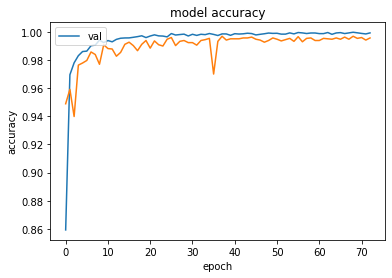

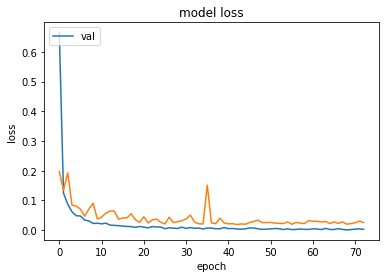

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 24ms/step - loss: 0.4877 - accuracy: 0.9476 - auc: 0.9831 - recall: 0.9465
Test loss:0.4877292513847351
Test accuracy:0.9475935697555542
Test Recall: 0.9465240836143494
Test AUC: 0.9830764532089233


# Train Full Manually Dataset 1

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 32)      1760        ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 32)     128         ['conv1d_9[0][0]']               
 rmalization)                                                                               

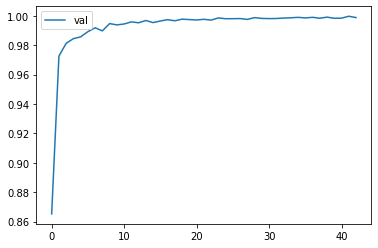

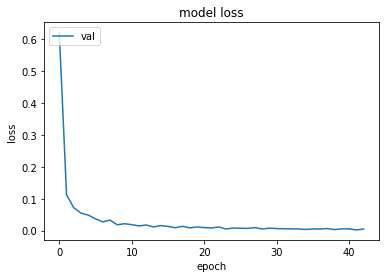

In [ ]:
#change 
epochs = 43
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 7s 28ms/step - loss: 0.5699 - accuracy: 0.9441 - auc: 0.9797 - recall: 0.9430
Test loss:0.5698601603507996
Test accuracy:0.9441176652908325
Test Recall: 0.9430481195449829
Test AUC: 0.9797155857086182


# Train 90%  Dataset 2

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      1760        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                               

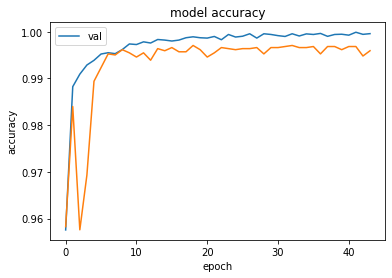

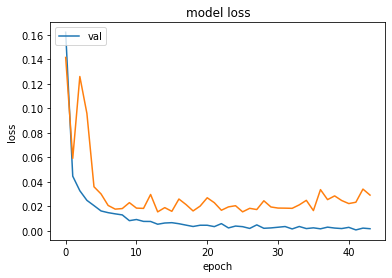

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 3s 22ms/step - loss: 0.1649 - accuracy: 0.9751 - auc: 0.9910 - recall: 0.9749
Test loss:0.16491949558258057
Test accuracy:0.9750810265541077
Test Recall: 0.9748784303665161
Test AUC: 0.9909706115722656


# Train Full Manually Dataset 2

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 32)      1760        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 32)     128         ['conv1d_6[0][0]']               
 rmalization)                                                                               

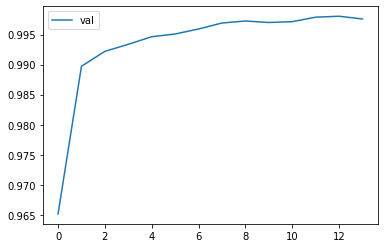

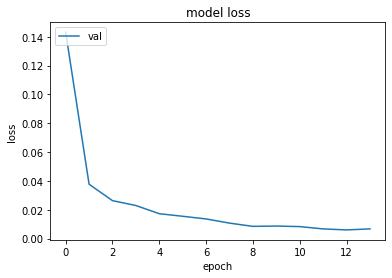

In [ ]:
#change
epochs = 14
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 9s 28ms/step - loss: 0.1516 - accuracy: 0.9731 - auc: 0.9926 - recall: 0.9720
Test loss:0.15164479613304138
Test accuracy:0.9730551242828369
Test Recall: 0.9720421433448792
Test AUC: 0.9926261901855469


# Train 90%  Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                              

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 32)      1760        ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 32)     128         ['conv1d_9[0][0]']               
 rmalization)                                                                               

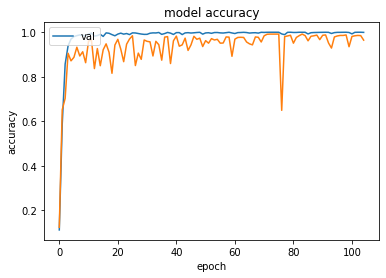

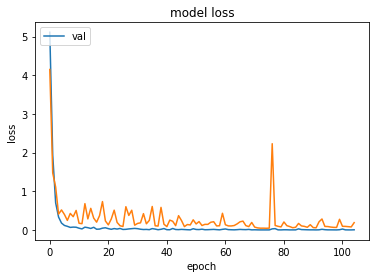

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 22ms/step - loss: 0.0782 - accuracy: 0.9830 - auc: 0.9979 - recall: 0.9815
Test loss:0.07818388193845749
Test accuracy:0.9829666614532471
Test Recall: 0.9815471768379211
Test AUC: 0.9978692531585693


# Train Full Manually Dataset OU-ISIR

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      1760        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                               

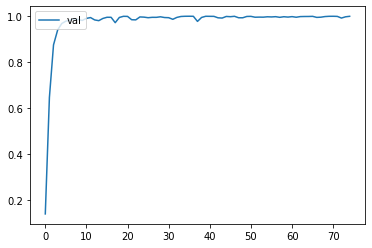

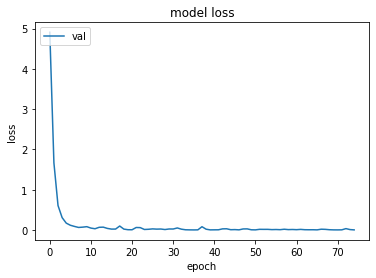

In [ ]:
# change
epochs = 75
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=epochs,verbose=1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=epochs,verbose=1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 5s 24ms/step - loss: 0.0827 - accuracy: 0.9830 - auc: 0.9979 - recall: 0.9773
Test loss:0.08274341374635696
Test accuracy:0.9829666614532471
Test Recall: 0.9772888422012329
Test AUC: 0.9978683590888977


# Train Dataset 1 test=val

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_4 (Permute)            (None, 128, 6)       0           ['input_5[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 128, 32)      1760        ['permute_4[0][0]']              
                                                                                                  
 batch_normalization_12 (BatchN  (None, 128, 32)     128         ['conv1d_12[0][0]']              
 ormalization)                                                                              

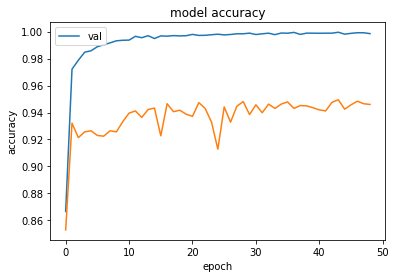

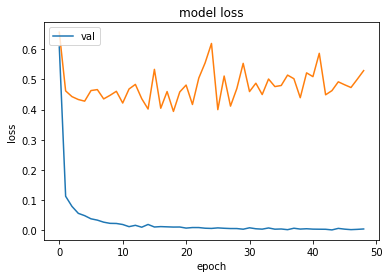

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 22ms/step - loss: 0.3940 - accuracy: 0.9417 - auc: 0.9849 - recall: 0.9401
Test loss:0.39398500323295593
Test accuracy:0.9417112469673157
Test Recall: 0.9401069283485413
Test AUC: 0.9849119782447815


# Train dataset 2 test = val

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                                                                   

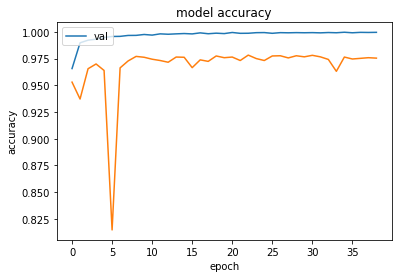

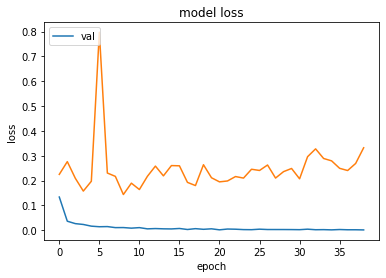

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 4s 28ms/step - loss: 0.1436 - accuracy: 0.9771 - auc: 0.9915 - recall: 0.9765
Test loss:0.1436169594526291
Test accuracy:0.9771069884300232
Test Recall: 0.9764991998672485
Test AUC: 0.991452693939209


#Train Test = val Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      1760        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                          

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 32)      1760        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 32)     128         ['conv1d_6[0][0]']               
 rmalization)                                                                               

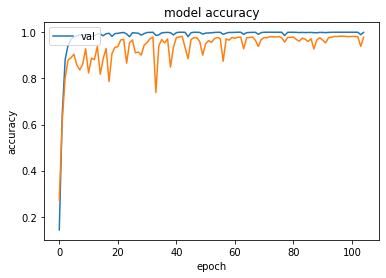

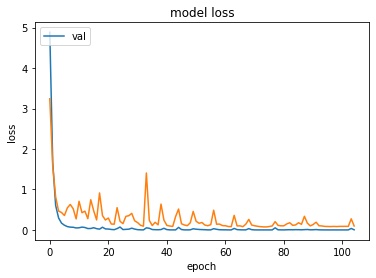

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 29ms/step - loss: 0.0738 - accuracy: 0.9794 - auc: 0.9975 - recall: 0.9780
Test loss:0.07383578270673752
Test accuracy:0.9794180393218994
Test Recall: 0.9779985547065735
Test AUC: 0.9975138306617737


# Tune Test - > val 



In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

In [ ]:
if gpu:
    tuner = kt.tuners.BayesianOptimization(post_se,
        objective='val_loss',
        max_trials=30,
        seed=42,
        project_name='/content/drive/Shareddrives/MMH//Model_gpu_1_test_val')
    # Will stop training if the "val_loss" hasn't improved in 30 epochs.
    tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)])

if tpu:
    with strategy.scope():
        tuner = kt.tuners.BayesianOptimization(post_se,
            objective='val_loss',
            max_trials=30,
            seed=42,
            project_name='Model_tpu_test')
        # Will stop training if the "val_loss" hasn't improved in 30 epochs.
        tuner.search(X_train, train_label, epochs=200, validation_data=(X_test,test_label), shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)])

Trial 31 Complete [00h 46m 33s]
val_loss: 0.37153223156929016

Best val_loss So Far: 0.367400586605072
Total elapsed time: 01h 40m 44s
INFO:tensorflow:Oracle triggered exit
Trial 31 Complete [00h 46m 33s]
val_loss: 0.37153223156929016

Best val_loss So Far: 0.367400586605072
Total elapsed time: 01h 40m 44s
INFO:tensorflow:Oracle triggered exit


# MODEL DEFINITION for Second Tuning

In [ ]:
def MLSTM_FCN_2(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(units=8))(x)
    x = Dropout(0.2)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

# Train Dataset 1 test=val

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     28160       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

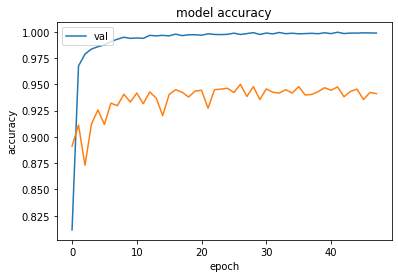

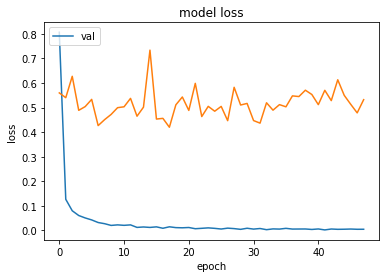

In [ ]:
checkpoint_filepath = '/content/1/checkpoint'
if gpu:
    model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[EarlyStopping('val_loss', patience=30,restore_best_weights=True),ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True,save_weights_only=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[EarlyStopping('val_loss', patience=30,restore_best_weights=True),ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True,save_weights_only=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
model.load_weights(checkpoint_filepath)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     28160       ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                                                               

In [ ]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 9s 24ms/step - loss: 0.4199 - accuracy: 0.9425 - auc: 0.9837 - recall: 0.9366
Test loss:0.4199281930923462
Test accuracy:0.9425133466720581
Test Recall: 0.9366310238838196
Test AUC: 0.9836937189102173


# Train dataset 2 test = val

In [ ]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 512)     28160       ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 512)    2048        ['conv1d[0][0]']                 
 alization)                                                                                   

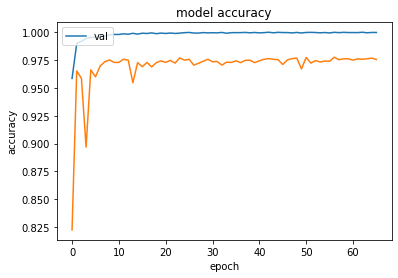

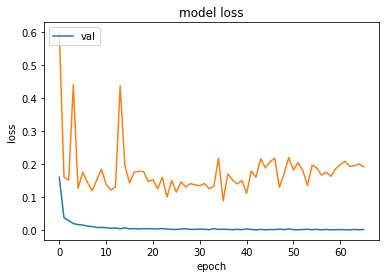

In [ ]:
checkpoint_filepath = '/content/2/checkpoint'
if gpu:
    model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[EarlyStopping('val_loss', patience=30,restore_best_weights=True),ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True,save_weights_only=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[EarlyStopping('val_loss', patience=30,restore_best_weights=True),ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True,save_weights_only=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
model.load_weights(checkpoint_filepath)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 512)     28160       ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 512)    2048        ['conv1d_3[0][0]']               
 rmalization)                                                                               

In [ ]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 10s 30ms/step - loss: 0.0884 - accuracy: 0.9743 - auc: 0.9991 - recall: 0.9726
Test loss:0.08837447315454483
Test accuracy:0.9742706418037415
Test Recall: 0.9726499319076538
Test AUC: 0.9990568161010742


#Train Test = val Dataset OU-ISIR

In [ ]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
# model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

(13212, 6, 128, 1) (1409, 6, 128, 1)


In [ ]:
checkpoint_filepath = '/content/ou/checkpoint'
if gpu:
    model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[EarlyStopping('val_loss', patience=30,restore_best_weights=True),ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True,save_weights_only=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[EarlyStopping('val_loss', patience=30,restore_best_weights=True),ModelCheckpoint(checkpoint_filepath, monitor='val_loss', save_best_only=True,save_weights_only=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
model = MLSTM_FCN_2((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
model.load_weights(checkpoint_filepath)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 512)     28160       ['permute_3[0][0]']              
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 128, 512)    2048        ['conv1d_9[0][0]']               
 rmalization)                                                                               

In [ ]:
get_test_performance(model, X_test, test_label)

# Sweeps

In [ ]:
! pip install wandb
! wandb login
# api key
# a010ea0446c414ae527dbbd97f2ecb938fbf0ac3

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="my-test-project", entity="nahian-alindo")

In [ ]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 100,
  "batch_size": 128
}

def build_model(shape, n_lstm, lstm_activation, recurr_activation, k_init_lstm,
                recurr_init, bias_init, k_regularizer_lstm, recurr_regularizer_lstm,
                bias_regularizer_lstm, activity_regularizer_lstm, drop_lstm, recurr_drop_lstm,
                drop_rate, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(units=8))(x)
    x = Dropout(rate=0.2, seed=42)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[WandbCallback()])

# Dataset 3

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(8))(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

(26283, 6, 128, 1) (2991, 6, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 32)      1760        ['permute[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 32)     128         ['conv1d[0][0]']                 
 alization)                                              

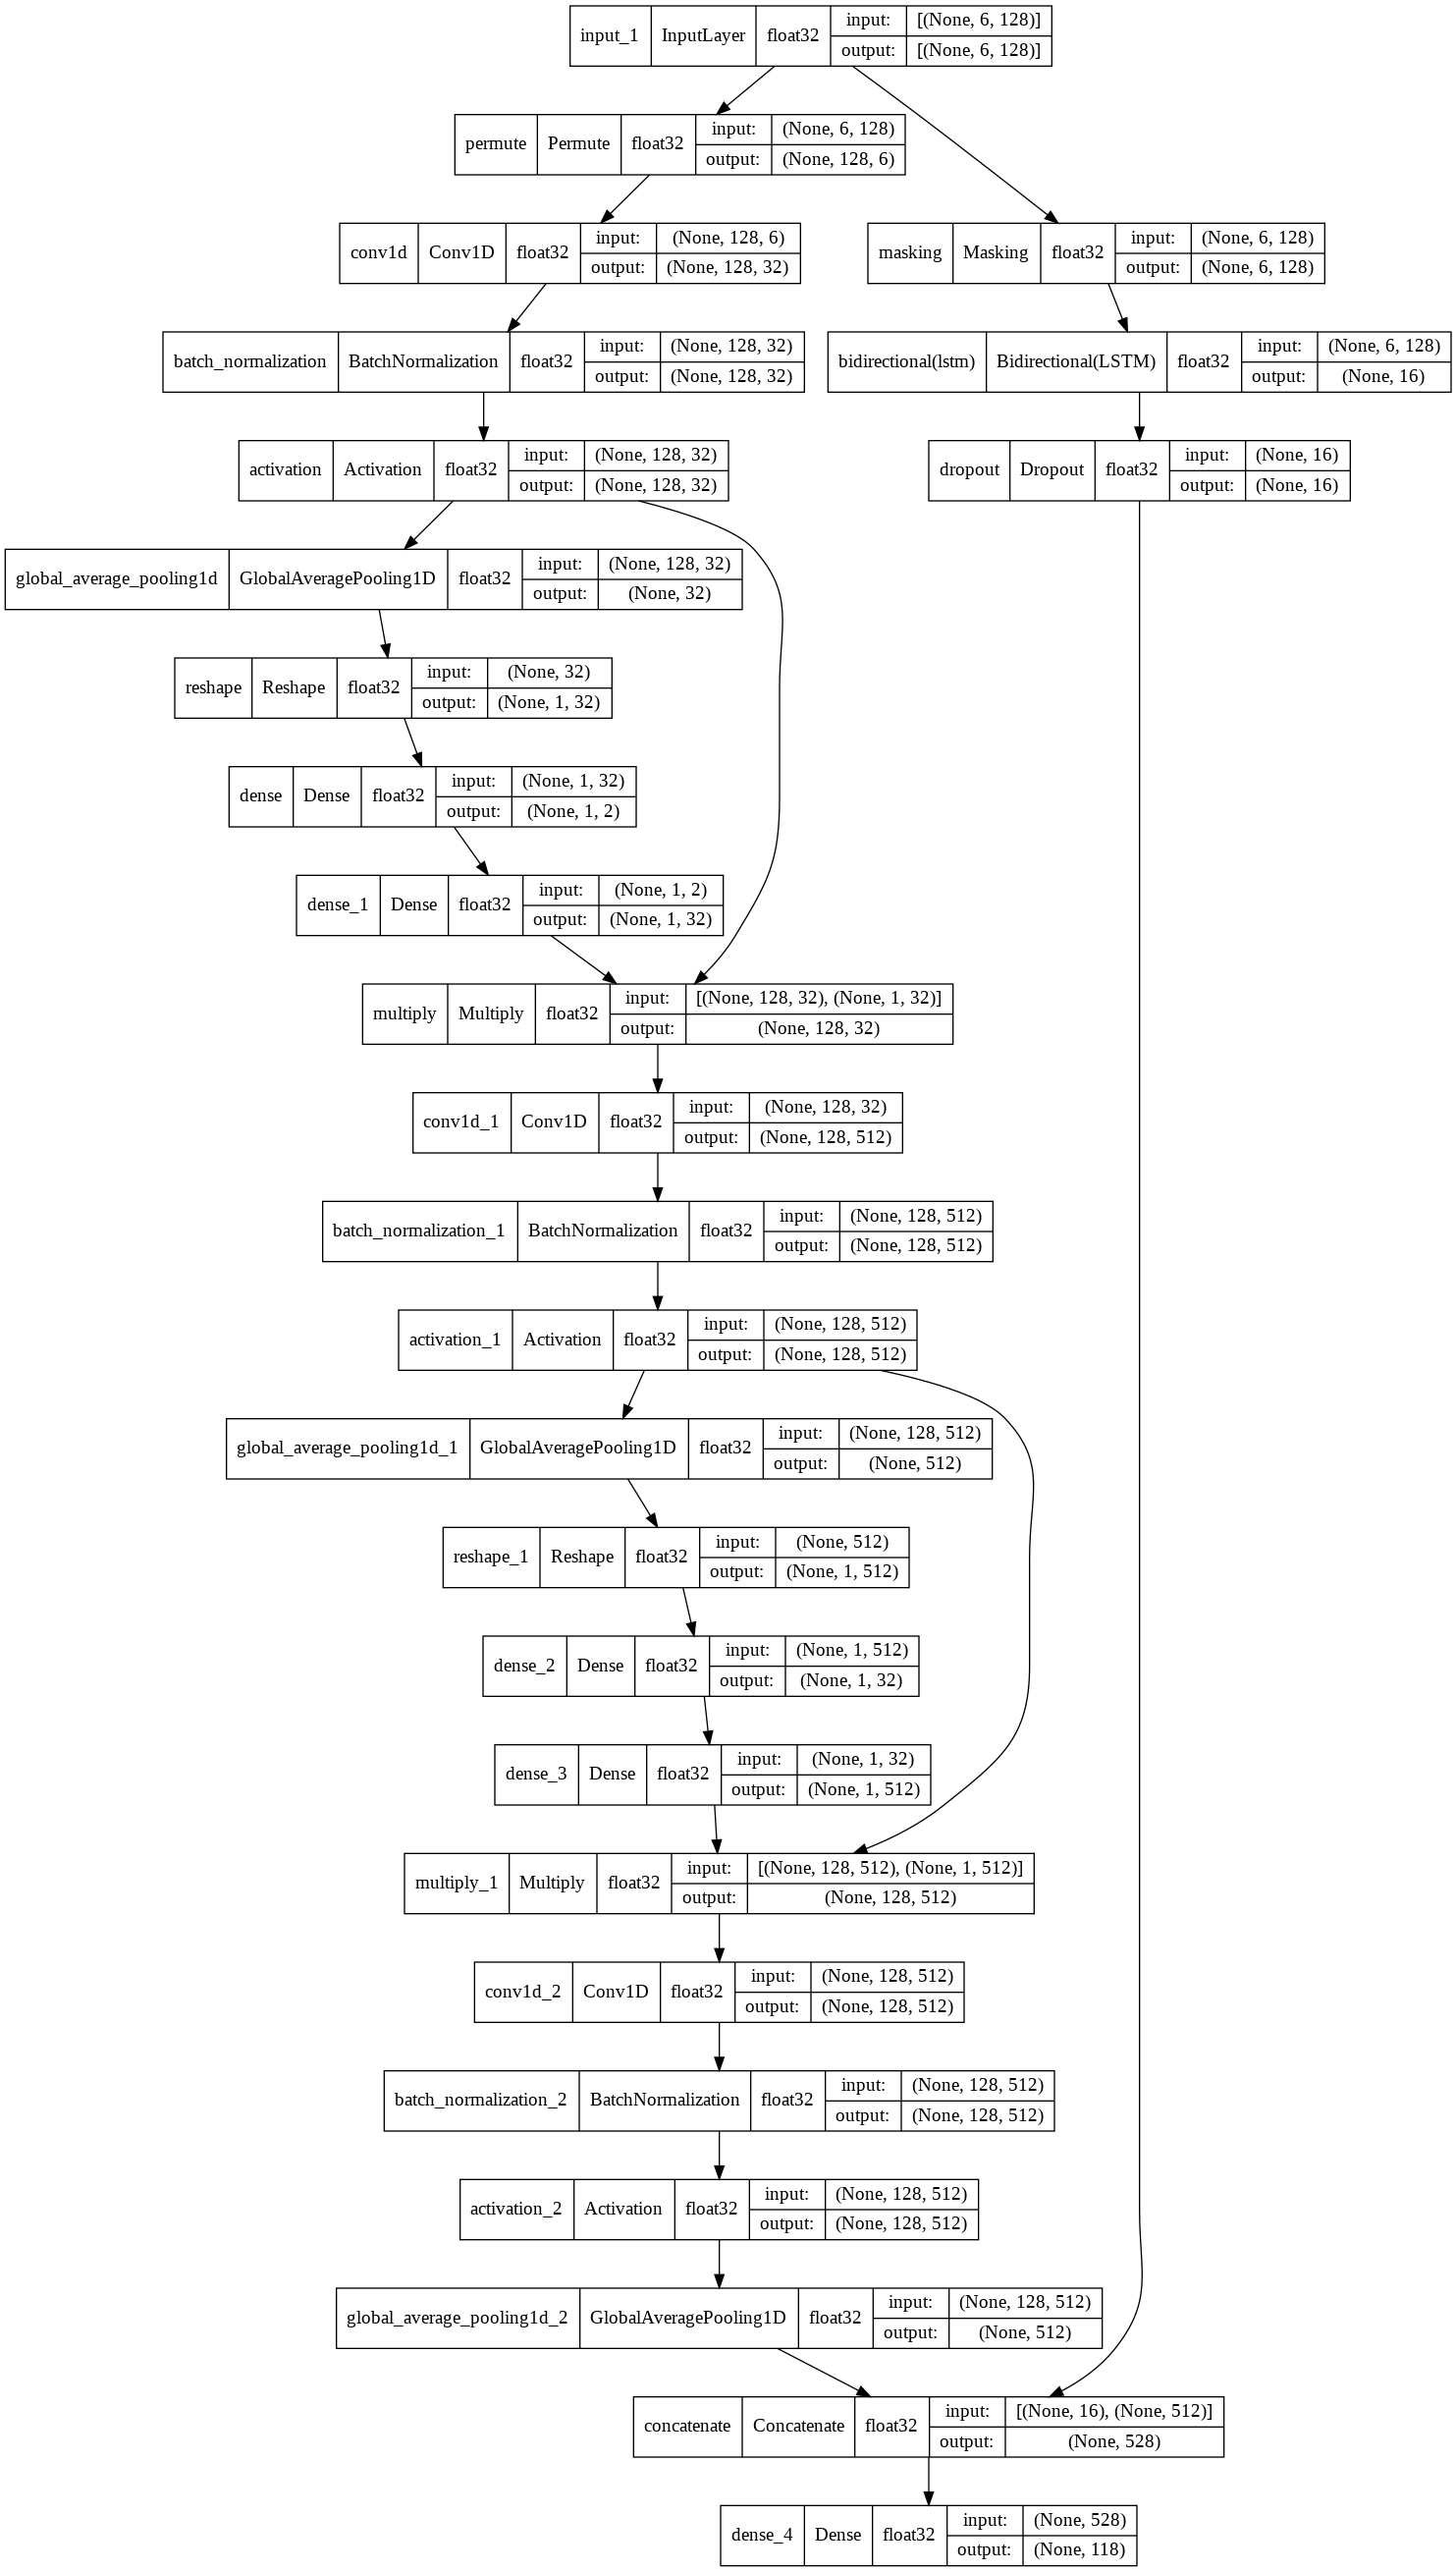

In [ ]:
num_classes = 118
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
tensorflow.keras.utils.plot_model(
    model, to_file='MLSTM_FCN_unified.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      1760        ['permute_1[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                               

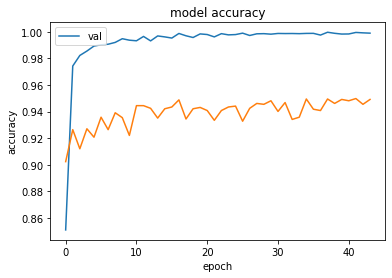

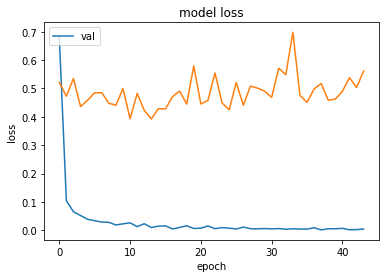

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

94/94 [==============================] - 2s 22ms/step - loss: 0.3925 - accuracy: 0.9351 - auc: 0.9836 - recall: 0.9328
Test loss:0.3924756348133087
Test accuracy:0.9351387619972229
Test Recall: 0.9327983856201172
Test AUC: 0.9836429953575134


# Dataset 4

In [ ]:
num_classes = 20
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(35373, 6, 128, 1) (3941, 6, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 128, 32)      1760        ['permute_2[0][0]']              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 128, 32)     128         ['conv1d_6[0][0]']               
 rmalization)                                          

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_data=(X_test,test_label))

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

In [ ]:
tensorflow.keras.utils.plot_model(
    model, to_file='MLSTM_FCN_unified2.png', show_shapes=False, show_dtype=False,
    show_layer_names=False, rankdir='TB', expand_nested=True, dpi=96
)

# Pre-SE

In [ ]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(units=8))(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = squeeze_excite_block(y)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

dataset 1 pre

In [ ]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 global_average_pooling1d (Glob  (None, 6)           0           ['permute[0][0]']                
 alAveragePooling1D)                                                                              
                                                                                                  
 reshape (Reshape)              (None, 1, 6)         0           ['global_average_pooling1d[0]

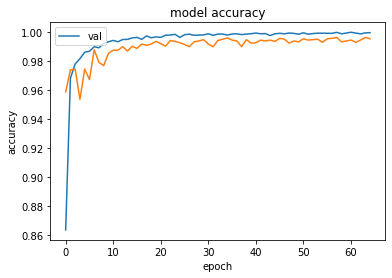

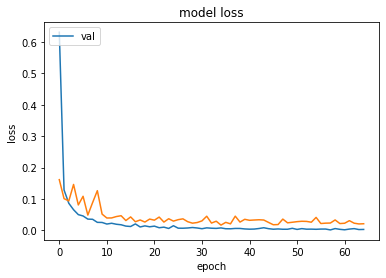

In [16]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [17]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 27ms/step - loss: 0.4684 - accuracy: 0.9495 - auc: 0.9837 - recall: 0.9471
Test loss:0.46841007471084595
Test accuracy:0.9494652152061462
Test Recall: 0.9470587968826294
Test AUC: 0.9837332963943481


dataset 2 pre

In [18]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 global_average_pooling1d_4 (Gl  (None, 6)           0           ['permute_1[0][0]']              
 obalAveragePooling1D)                                                                            
                                                                                                  
 reshape_3 (Reshape)            (None, 1, 6)         0           ['global_average_pooling1d_

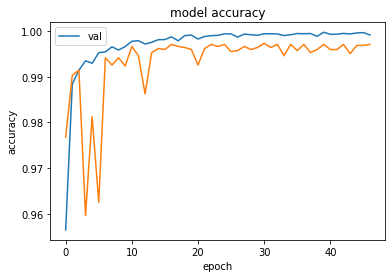

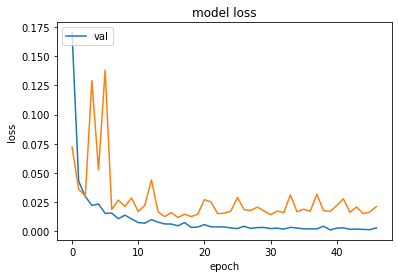

In [19]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [20]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 4s 27ms/step - loss: 0.3074 - accuracy: 0.9763 - auc: 0.9900 - recall: 0.9743
Test loss:0.30738595128059387
Test accuracy:0.976296603679657
Test Recall: 0.9742706418037415
Test AUC: 0.9900354743003845


dataset ou pre

In [21]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 global_average_pooling1d_8 (Gl  (None, 6)           0           ['permute_2[0][0]']              
 obalAveragePooling1D)                                                                            
                                                                                                  
 reshape_6 (Reshape)            (None, 1, 6)         0 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 global_average_pooling1d_12 (G  (None, 6)           0           ['permute_3[0][0]']              
 lobalAveragePooling1D)                                                                           
                                                                                                  
 reshape_9 (Reshape)            (None, 1, 6)         0           ['global_average_pooling1d_

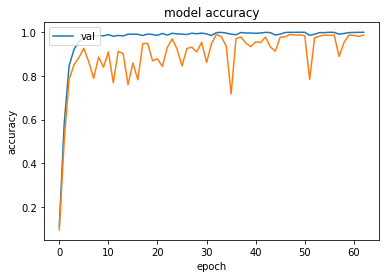

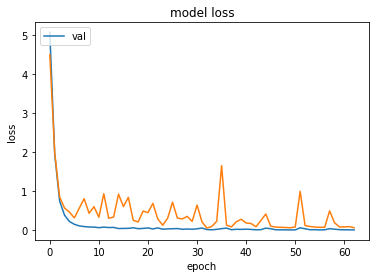

In [22]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [23]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 27ms/step - loss: 0.1292 - accuracy: 0.9674 - auc: 0.9975 - recall: 0.9624
Test loss:0.12915754318237305
Test accuracy:0.9673527479171753
Test Recall: 0.9623846411705017
Test AUC: 0.9975083470344543


dataset 3 pre

In [24]:
num_classes = 118
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(26283, 6, 128, 1) (2991, 6, 128, 1)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_4 (Permute)            (None, 128, 6)       0           ['input_5[0][0]']                
                                                                                                  
 global_average_pooling1d_16 (G  (None, 6)           0           ['permute_4[0][0]']              
 lobalAveragePooling1D)                                                                           
                                                                                                  
 reshape_12 (Reshape)           (None, 1, 6)         0 

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_5 (Permute)            (None, 128, 6)       0           ['input_6[0][0]']                
                                                                                                  
 global_average_pooling1d_20 (G  (None, 6)           0           ['permute_5[0][0]']              
 lobalAveragePooling1D)                                                                           
                                                                                                  
 reshape_15 (Reshape)           (None, 1, 6)         0           ['global_average_pooling1d_

In [ ]:
get_test_performance(model, X_test, test_label)

dataset 4 pre

In [ ]:
num_classes = 20
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

#Identity Squeeze

In [14]:
def MLSTM_FCN(shape, num_classes):
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = Bidirectional(LSTM(units=8))(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    z = squeeze_excite_block(y)
    y = Conv1D(32, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = concatenate([z,y])
    z2= squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = concatenate([z2,y])
    
    ### layer added
    z3= squeeze_excite_block(y)
    y = Conv1D(512, 9, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = concatenate([z3,y])
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=['accuracy','AUC','Recall'])
    model.summary()

    return model

dataset 1 identity

In [15]:
np.random.seed(42)
num_classes = 118
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #1/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute (Permute)              (None, 128, 6)       0           ['input_1[0][0]']                
                                                                                                  
 global_average_pooling1d (Glob  (None, 6)           0           ['permute[0][0]']                
 alAveragePooling1D)                                                                              
                                                                                                  
 reshape (Reshape)              (None, 1, 6)         0           ['global_average_pooling1d[0]

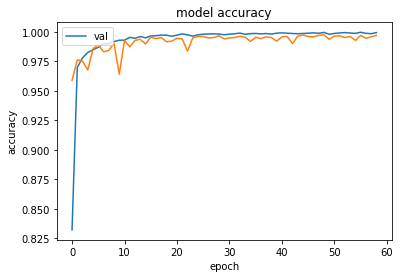

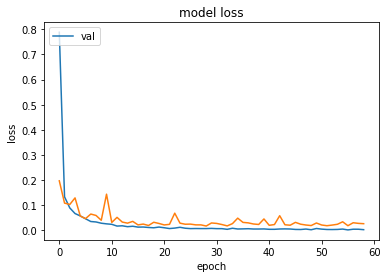

In [16]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [17]:
get_test_performance(model, X_test, test_label)

117/117 [==============================] - 3s 29ms/step - loss: 0.4036 - accuracy: 0.9527 - auc: 0.9847 - recall: 0.9492
Test loss:0.40357089042663574
Test accuracy:0.9526737928390503
Test Recall: 0.9491978883743286
Test AUC: 0.9846784472465515


dataset 2 identity

In [18]:
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
shape = ((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
num_classes = 20
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_1 (Permute)            (None, 128, 6)       0           ['input_2[0][0]']                
                                                                                                  
 global_average_pooling1d_4 (Gl  (None, 6)           0           ['permute_1[0][0]']              
 obalAveragePooling1D)                                                                            
                                                                                                  
 reshape_3 (Reshape)            (None, 1, 6)         0           ['global_average_pooling1d_

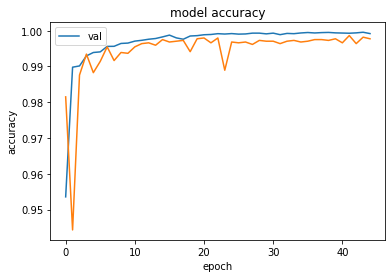

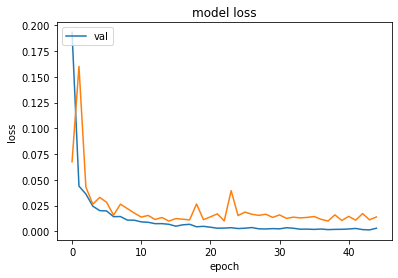

In [19]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [20]:
get_test_performance(model, X_test, test_label)

155/155 [==============================] - 4s 29ms/step - loss: 0.2633 - accuracy: 0.9761 - auc: 0.9902 - recall: 0.9753
Test loss:0.26329106092453003
Test accuracy:0.9760940074920654
Test Recall: 0.9752836227416992
Test AUC: 0.9901671409606934


dataset ou identity

In [21]:
num_classes = 745
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/data')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/data')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/train/train_y.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/OU-ISIR_sensors_dataset/identification/data/test/test_y.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
cyclical_learning_rate = CyclicalLearningRate(
    initial_learning_rate=0.0001,maximal_learning_rate=0.1,step_size=(X_train[0]*0.9*10)/32,scale_fn=lambda x: 1 / (2.0 ** (x - 1)),scale_mode='cycle')

(13212, 6, 128, 1) (1409, 6, 128, 1)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_2 (Permute)            (None, 128, 6)       0           ['input_3[0][0]']                
                                                                                                  
 global_average_pooling1d_8 (Gl  (None, 6)           0           ['permute_2[0][0]']              
 obalAveragePooling1D)                                                                            
                                                                                                  
 reshape_6 (Reshape)            (None, 1, 6)         0 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_3 (Permute)            (None, 128, 6)       0           ['input_4[0][0]']                
                                                                                                  
 global_average_pooling1d_12 (G  (None, 6)           0           ['permute_3[0][0]']              
 lobalAveragePooling1D)                                                                           
                                                                                                  
 reshape_9 (Reshape)            (None, 1, 6)         0           ['global_average_pooling1d_

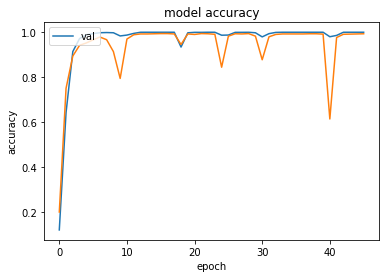

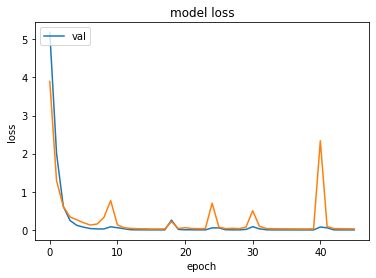

In [22]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [23]:
get_test_performance(model, X_test, test_label)

45/45 [==============================] - 1s 28ms/step - loss: 0.0828 - accuracy: 0.9766 - auc: 0.9989 - recall: 0.9730
Test loss:0.08279483020305634
Test accuracy:0.9765791296958923
Test Recall: 0.9730305075645447
Test AUC: 0.9989314675331116


dataset 3 identity

In [24]:
num_classes = 118
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #3/Dataset #3/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

(26283, 6, 128, 1) (2991, 6, 128, 1)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 permute_4 (Permute)            (None, 128, 6)       0           ['input_5[0][0]']                
                                                                                                  
 global_average_pooling1d_16 (G  (None, 6)           0           ['permute_4[0][0]']              
 lobalAveragePooling1D)                                                                           
                                                                                                  
 reshape_12 (Reshape)           (None, 1, 6)         0 

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)

dataset 4 identity

In [ ]:
num_classes = 20
np.random.seed(42)
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #4/test/y_test.txt')
print(f'{X_train.shape} {X_test.shape}')
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

In [ ]:
if gpu:
    model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
    history = model.fit(X_train,train_label,batch_size=32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)
if tpu:
    with strategy.scope():
        model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])
        history = model.fit(X_train,train_label,batch_size=8*32,epochs=200,verbose=1,callbacks=[tensorflow.keras.callbacks.EarlyStopping('val_loss', patience=30,restore_best_weights=True)],validation_split=0.1)

plot_performance(X_train, train_label, history)

In [ ]:
get_test_performance(model, X_test, test_label)